inputs: best_model/

contents: evaluating the model

In [32]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

In [33]:
import mlflow
pipeline = mlflow.sklearn.load_model("best_model")

In [34]:
pipeline

Pipeline(steps=[('selector',
                 DataFrameSelector(attribute_names=Index(['age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object'))),
                ('preprocessor', DataPreprocessor()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               c...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [35]:
import pandas as pd
test_df = pd.read_csv("data/test_df.csv")

In [36]:
predictions = pipeline.predict_proba(test_df)

In [37]:
import yaml
with open('data/heart_disease_metadata.yaml', 'r') as f:
    metadata = yaml.safe_load(f)

In [38]:
import shap
# analyze the predictions using shap
model = pipeline.named_steps['classifier']

# Extract the preprocessing steps from the pipeline
# Assuming 'classifier' is the last step in the pipeline
preprocessing_pipeline = pipeline[:-1]  # Exclude the last step (classifier)

# Transform the input data using the preprocessing steps
preprocessed_input = preprocessing_pipeline.transform(test_df)

# Extract the XGBoost model from the pipeline
model = pipeline.named_steps['classifier']

feature_names = test_df.columns
feature_titles = [metadata[col]['title'] if col in metadata and 'title' in metadata[col] else col for col in feature_names]
explainer = shap.TreeExplainer(model)
shap_values = explainer(preprocessed_input)


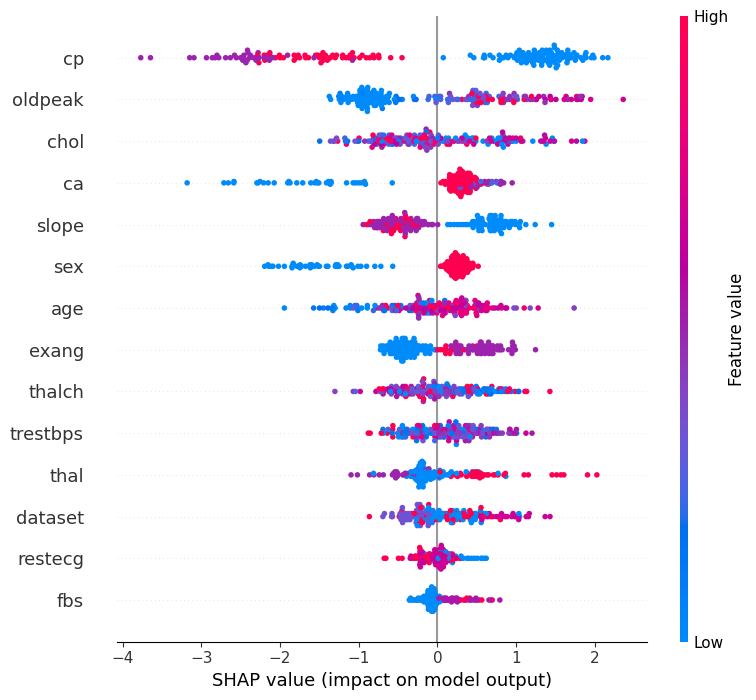

In [39]:
shap.summary_plot(shap_values, preprocessed_input)

In [40]:
preprocessed_input

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,8,1,1,1,16,20,0,2,79,0,10,2,4,1
1,17,1,1,1,31,76,1,2,21,0,10,2,4,1
2,20,1,1,0,43,175,0,2,111,1,25,1,4,1
3,31,1,0,0,44,30,1,0,109,0,20,1,2,0
4,12,0,1,0,37,200,0,2,29,0,30,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,18,1,1,1,31,127,0,2,64,1,10,2,4,1
180,32,0,0,0,37,110,0,0,56,0,36,1,2,3
181,33,1,3,2,16,181,0,2,117,1,10,2,4,1
182,27,1,1,0,16,122,0,2,39,0,10,2,4,1


In [45]:
shap_values[0, :]

.values =
array([-1.1057652 ,  0.21425161, -0.2212994 , -3.6472182 , -0.04735207,
       -0.5791445 , -0.10886863, -0.18943208, -0.61320287, -0.37652576,
       -0.7846705 , -0.60181385,  0.23192853, -0.23656884], dtype=float32)

.base_values =
np.float32(0.21834725)

.data =
array([ 8,  1,  1,  1, 16, 20,  0,  2, 79,  0, 10,  2,  4,  1])

In [46]:
preprocessed_input.iloc[0, :]

age          8
sex          1
dataset      1
cp           1
trestbps    16
chol        20
fbs          0
restecg      2
thalch      79
exang        0
oldpeak     10
slope        2
ca           4
thal         1
Name: 0, dtype: int64

In [ ]:
# show shap force plot for the first row
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :].values, preprocessed_input.iloc[0, :])

In [51]:
shap.force_plot(explainer.expected_value, shap_values[:1000, :].values, preprocessed_input.iloc[:1000, :])